# From Cartool inverse solutions to MNE functional connectivity

In [2]:
pip install tqdm pycartool

  Created wheel for pycartool: filename=pycartool-0.1.1-py3-none-any.whl size=16978 sha256=0771428d4952f58bee40fdf4d4b6f210f8da9aa3ec8b77c169b93d3314254eb2
  Stored in directory: /home/tourbier/.cache/pip/wheels/07/57/54/490e9e1655a2be988dc15a0995fc28b84ec0d0ea520d1107f8
Successfully built pycartool
Note: you may need to restart the kernel to use updated packages.


## 0) Prepare data

#### 0.1) Import necessary packages 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne

import pycartool

#### 0.2) Set paths

In [13]:
# Path to data
USR = os.getenv('USER')

#datafold = "/Users/sebastientourbier/Desktop/DS001-sample"
datafold = "/mnt/c/Users/tourbier/OHBMBrainHack2020/Data/DS001-sample/"

# Path to EEGlab files
EEG_path = os.path.join(datafold,'derivatives','eeglab') 

# Path to leadfield matrices
IS_path = ''
# Path to save output figures

#### 0.3) Select subject

In [14]:
sub = 1
subject = str(sub).zfill(2)
print(subject)

01


# 1) Scalp analysis

#### 1.1) Load eeg data

In [15]:
# Load EEG data into a 3d array with shape (#trials, #electrodes, # samples)
EEG_fname = os.path.join(EEG_path,'sub-'+subject,'eeg','sub-'+subject+'_task-Face_eeg.set') 
print(EEG_fname)
epochs = mne.read_epochs_eeglab(EEG_fname, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)


/mnt/c/Users/tourbier/OHBMBrainHack2020/Data/DS001-sample/derivatives/eeglab/sub-01/eeg/sub-01_task-Face_eeg.set
Extracting parameters from /mnt/c/Users/tourbier/OHBMBrainHack2020/Data/DS001-sample/derivatives/eeglab/sub-01/eeg/sub-01_task-Face_eeg.set...


<ipython-input-15-977908ef233c>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(EEG_fname, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)
<ipython-input-15-977908ef233c>:4: RuntimeWarning: Data file name in EEG.data (01_DNP_FACES_PREPROCESSED.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-01_task-Face_eeg.fdt).
  epochs = mne.read_epochs_eeglab(EEG_fname, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)


588 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


Creating RawArray with float64 data, n_channels=128, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


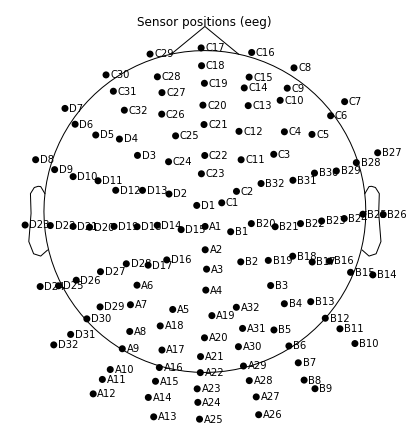

Applying baseline correction (mode: mean)
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
588 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


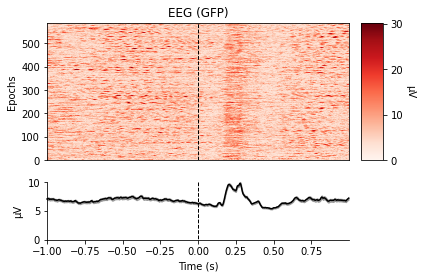

No baseline correction applied


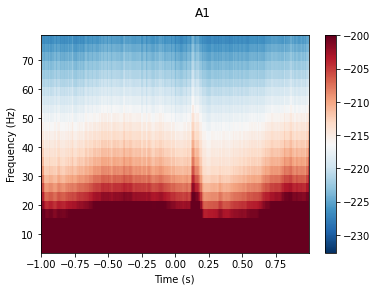

In [16]:
# Load EEG electrode locations and transformation matrix to the original space

montage_fname = os.path.join(datafold,'derivatives','cartool','sub-'+subject,'sub-'+subject+'.xyz')
dev_head_t_fname = os.path.join(datafold,'derivatives','cartool','sub-'+subject,'More','sub-'+subject+'.Transform.Electrodes Coregistration.Electrodes to Original MRI.txt')
dev_head_t = np.loadtxt(dev_head_t_fname)

n = int(open(montage_fname).readline().lstrip().split(' ')[0])
all_coord = np.loadtxt(montage_fname, skiprows=1, usecols=(0, 1, 2))
all_names = np.loadtxt(montage_fname, skiprows=1, usecols=3,dtype=np.dtype(str)).tolist()
all_coord = list(map(lambda x: x/1000,all_coord))
#all_coord = list(map(lambda x: np.dot(dev_head_t[:3,:],np.concatenate((x,[1])))/1000,all_coord))

nas_coord = all_coord[all_names.index('nasion')]
lpa_coord = all_coord[all_names.index('lpa')]
rpa_coord = all_coord[all_names.index('rpa')]
ch_coord  = [all_coord[idx] for idx, chan in  enumerate(all_names) if chan not in ['lpa','rpa','nasion']]
ch_names  = [all_names[idx] for idx, chan in  enumerate(all_names) if chan not in ['lpa','rpa','nasion']]



montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, ch_coord)),nasion=nas_coord,rpa=rpa_coord,lpa=lpa_coord,coord_frame='head')
montage.dev_head_t = dev_head_t

mne_derivatives = os.path.join(datafold,'derivatives','mne','sub-'+subject)
if not os.path.exists(mne_derivatives):
    os.makedirs(mne_derivatives)  
fif_fname = os.path.join(datafold,'derivatives','mne','sub-'+subject,'sub-'+subject+'_montage.fif')
montage.save(fif_fname)

montage.plot();
epochs.set_montage(montage)
epochs.apply_baseline((0,None))
epochs.set_eeg_reference('average',projection = True)
epochs.apply_proj()
epochs.plot_image()

frequencies = np.arange(5, 80, 3)
power = mne.time_frequency.tfr_morlet(epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(dB='True',vmax = -200);

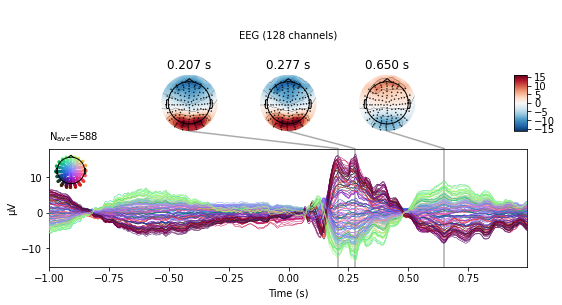

In [17]:
evoked = epochs.average()
evoked.plot_joint();

In [23]:
ls /mnt/c/Users/tourbier/OHBMBrainHack2020/Data/DS001-sample/derivatives/eeglab/sub-01/eeg/

sub-01_task-Face_eeg.fdt*  sub-01_task-Face_events.txt*
sub-01_task-Face_eeg.set*


#### 1.2) Load behavioral data

In [24]:
# Load epoch metadata into a table with header [COND, ACC, RT, nameCOND, outliers, bat_trials]
Behav_path = os.path.join(EEG_path,'sub-'+subject,'eeg','sub-'+subject+'_task-Face_events.txt')
Behavfile = pd.read_csv(Behav_path, sep=",")
Behavfile = Behavfile[Behavfile.bad_trials == 0]
epochs.events[:,2] = list(Behavfile.COND)
epochs.event_id = {"Scrambled":0, "Faces":1}

Scra_epochs =epochs['Scrambled']
Face_epochs = epochs['Faces']

#### 1.3) Plot scalp eeg data (GFP)

294 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


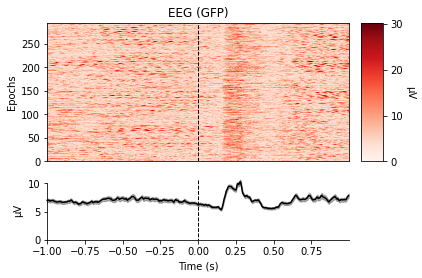

294 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


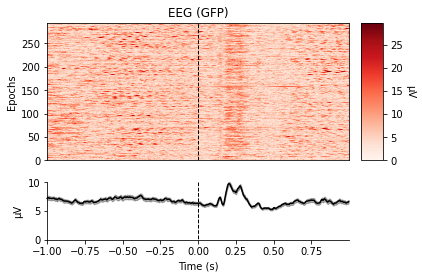

[<Figure size 432x288 with 3 Axes>]

In [25]:
Scra_epochs.plot_image()
Face_epochs.plot_image()
# Check this out : https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.plot_image

#### 1.4) Plot spectrum for different conditions

In [26]:
frequencies = np.arange(5, 80, 3)
power_scra = mne.time_frequency.tfr_morlet(Scra_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power_faces = mne.time_frequency.tfr_morlet(Face_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)

No baseline correction applied


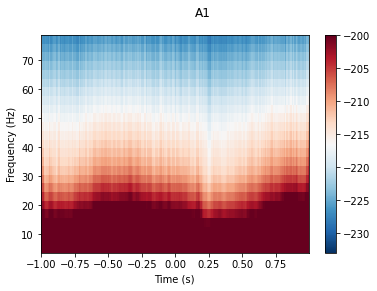

No baseline correction applied


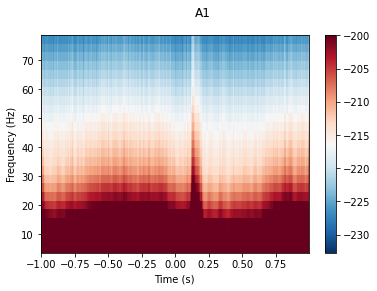

In [27]:
power_scra.plot(dB='True',vmax = -200)
power_faces.plot(dB='True',vmax = -200);

#### 1.5) Different ERP plots

combining channels using "gfp"
combining channels using "gfp"


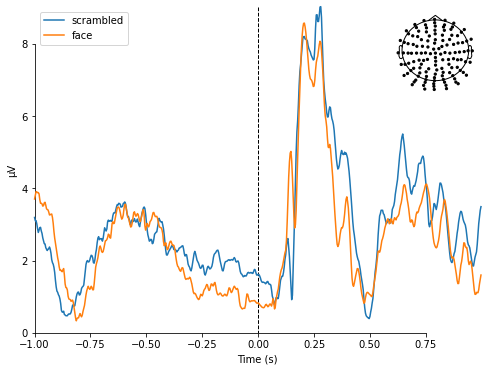

In [28]:
scra_evoked = Scra_epochs.average()
face_evoked = Face_epochs.average()

mne.viz.plot_compare_evokeds(dict(scrambled=scra_evoked, face=face_evoked),
                             legend='upper left', show_sensors='upper right');

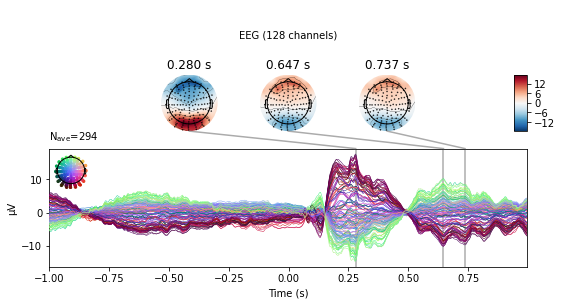

In [29]:
scra_evoked.plot_joint();

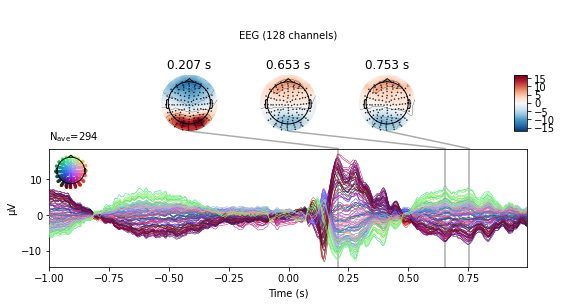

In [30]:
face_evoked.plot_joint();

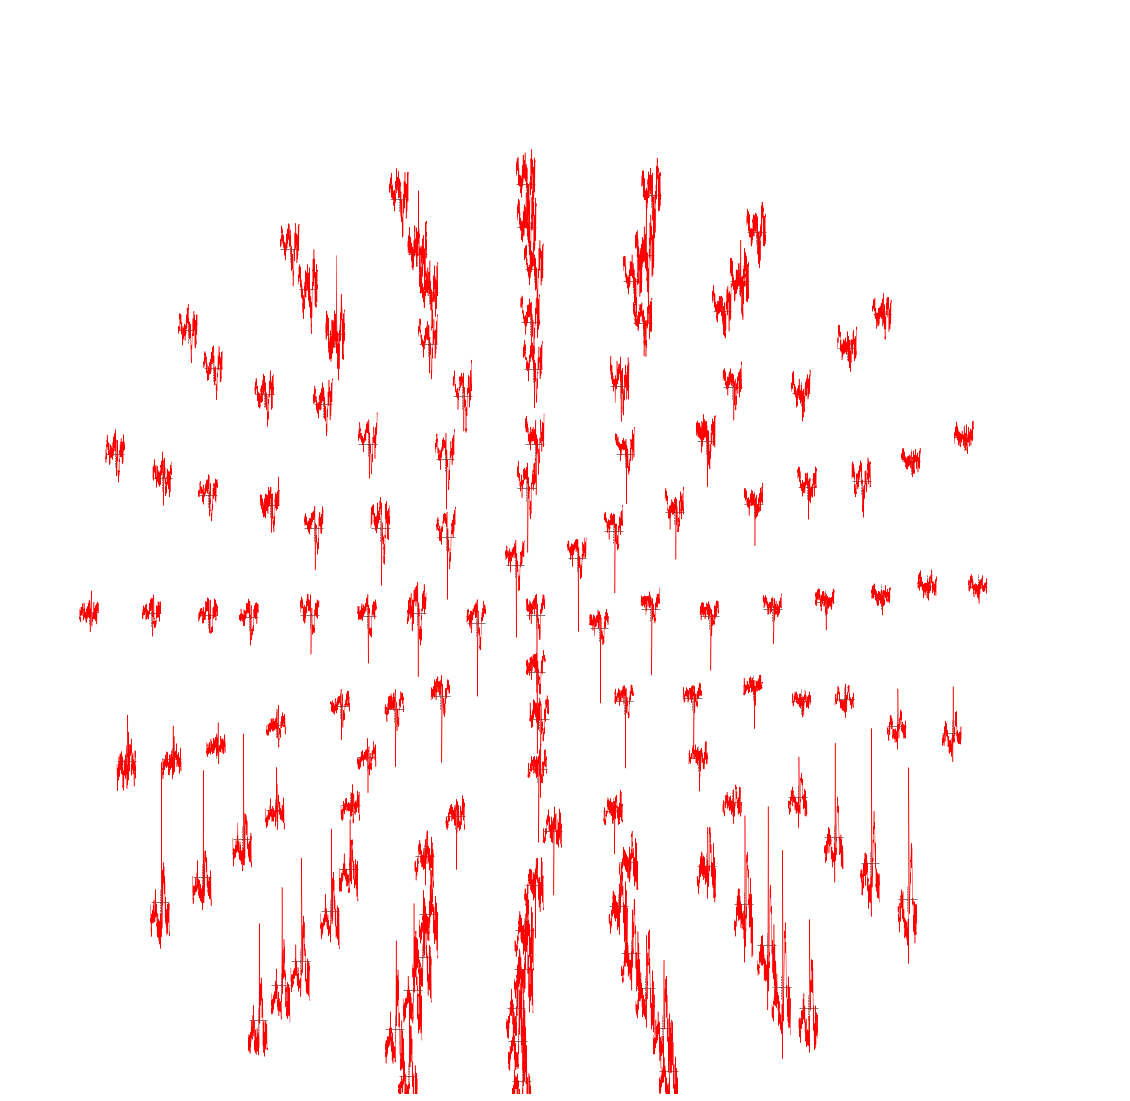

In [31]:
fig, axs = plt.subplots(figsize=(20,20))
evoked_diff = mne.combine_evoked([scra_evoked, -face_evoked], weights='equal')
evoked_diff.plot_topo(color='r', legend=False,axes = axs ,ylim ={'eeg':[-1,1]});

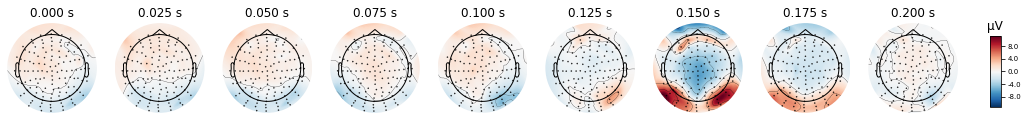

In [32]:
evoked_diff.plot_topomap(times=[0., 0.025, 0.05, .075,0.10,.125,.15,0.175, 0.2], ch_type='eeg');

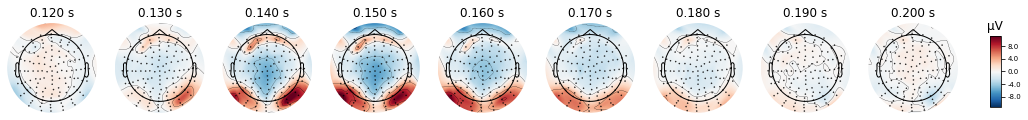

In [33]:
evoked_diff.plot_topomap(times=[.12,.13,.14,.15,.16,0.17,.18,.19,.2], ch_type='eeg');

"""
tmin = -100
tmax = 600

time_vec = np.where((EEGfile.times>=tmin/1000) & (EEGfile.times<=tmax/1000))[0]
time = EEGfile.times[time_vec]
data_plot = EEGdata[:,:,time_vec]

dt = time[1]-time[0]
trials0 = np.arange(np.sum(trials_cond0))
trials1 = np.arange(np.sum(trials_cond1))
channels = np.arange(len(EEGfile.ch_names))
extent0 = [time[0]-dt, time[-1]+dt, trials0[0]-1, trials0[-1]+1]
extent1 = [time[0]-dt, time[-1]+dt, trials1[0]-1, trials1[-1]+1]
extent2 = [time[0]-dt, time[-1]+dt, channels[0]-1, channels[-1]+1]


minval = np.min(EEGdata.mean(0).mean(0))
maxval = np.max(EEGdata.mean(0).mean(0))

fig,axs = plt.subplots(2,3,figsize=(20,25))
axs[0,0].imshow(data_plot[trials_cond0,:,:].mean(1),cmap='coolwarm',extent = extent0, aspect='auto')
axs[0,0].tick_params(axis='both', which='major', labelsize=20)
axs[0,0].set_xlabel('time [s]',fontsize=20)
axs[0,0].set_ylabel('Epoch',fontsize=20)
axs[0,0].set_title('Condition = 0',fontsize=20)
axs[0,0].axvline(x=0,color='k')

axs[0,1].imshow(data_plot[trials_cond1].mean(1),cmap='coolwarm',extent = extent1, aspect='auto')
axs[0,1].tick_params(axis='both', which='major', labelsize=20)
axs[0,1].set_ylabel('Epoch',fontsize=20)
axs[0,1].set_xlabel('time [s]',fontsize=20)
axs[0,1].set_title('Condition = 1',fontsize=20)
axs[0,1].axvline(x=0,color='k')

axs[0,2].imshow(data_plot[trials_cond1].mean(0)-data_plot[trials_cond0].mean(0),cmap='coolwarm',extent = extent2, aspect='auto')
axs[0,2].tick_params(axis='both', which='major', labelsize=20)
axs[0,2].set_ylabel('Electrode',fontsize=20)
axs[0,2].set_xlabel('time [s]',fontsize=20)
axs[0,2].set_title('Difference',fontsize=20)
axs[0,2].axvline(x=0,color='k')

axs[1,0].plot(time,data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[1,0].axvline(x=0,color='k')
axs[1,0].axhline(y=0,color='k')

axs[1,1].plot(time,data_plot[trials_cond1].mean(0).T,'grey',linewidth=.5)
axs[1,1].axvline(x=0,color='k')
axs[1,1].axhline(y=0,color='k')

axs[1,2].plot(time,data_plot[trials_cond1].mean(0).T-data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[1,2].axvline(x=0,color='k')
axs[1,2].axhline(y=0,color='k')


axs[2,0].plot(time,data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[2,0].axvline(x=0,color='k')
axs[2,0].axhline(y=0,color='k')

axs[2,1].plot(time,data_plot[trials_cond1].mean(0).T,'grey',linewidth=.5)
axs[2,1].axvline(x=0,color='k')
axs[2,1].axhline(y=0,color='k')

axs[2,2].plot(time,data_plot[trials_cond1].mean(0).T-data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[2,2].axvline(x=0,color='k')
axs[2,2].axhline(y=0,color='k')
"""



"""ax.plot(EEGfile.times,EEGdata[trials_cond0,5,:].T,'r',linewidth=0.1)
ax.plot(EEGfile.times,np.mean(EEGdata[trials_cond0,5,:],axis =0),'k')
ax.fill_between(EEGfile.times, np.percentile(EEGdata[trials_cond0,5,:],5,axis =0), np.percentile(EEGdata[trials_cond0,5,:],95,axis =0),
    alpha=0., edgecolor='k', facecolor='k')"""

# 2) Source analysis

#### 2.1) Source localization (using Cartool IS, project_dipoles_inv3D, SVD, and group_signflip)

In [34]:
# Loop across subjects
# get ROI parcellations index
roi_filename = os.path.join(datafold,'derivatives','cartool','sub-'+subject,'More','ROI_33','sub-'+subject+'.rois')
roi_file = pycartool.regions_of_interest.read_roi(roi_filename)
# get IS (Laura inverse solution)
is_filename = os.path.join(datafold,'derivatives','cartool','sub-'+subject,'sub-'+subject+'.Laura.is')
is_file = pycartool.io.inverse_solution.read_is(is_filename)

# load EEG data (all trials)
# compute inverse solutions for each ROI

IS = is_file['regularisation_solutions'][12]

RO01
Dimension_of_original_data: 5008
Number of ROI: 82
Reading /mnt/c/Users/tourbier/OHBMBrainHack2020/Data/DS001-sample/derivatives/cartool/sub-01/sub-01.Laura.is
Reading Header...
IS type: IS03
n_channels: 131
n_solutionpoints: 5008
n_regularizations: 13
Inverse solution is Vectorial
Reading Variable Header...
Regularizations values: [0.0, 26.14055, 52.2811, 78.42165, 104.5622, 130.70275, 156.8433, 182.98385000000002, 209.1244, 235.26495, 261.4055, 287.54605000000004, 313.6866]
Regularizations names: ['Regularization  0', 'Regularization  1', 'Regularization  2', 'Regularization  3', 'Regularization  4', 'Regularization  5', 'Regularization  6', 'Regularization  7', 'Regularization  8', 'Regularization  9', 'Regularization 10', 'Regularization 11', 'Regularization 12']


In [35]:
def project_dipoles_inv3D(EEGfile,roi_file,IS,spi_file,time):
    """ 
    This function gathers the functions solveinv3d.m and project_dipoles.m
    Joan Rué
    Last modification 7/03/2019"""
    
    eegdata = EEGfile.get_data()
    conds = EEGfile.events[:,2]   
    nconds = len(np.unique(conds))
    N = len(roi_file.names) #% number of ROIs
    E, _, T = eegdata.shape # Epochs,  _ , Time
    TCs_1D = np.zeros((N,T,E)) # full time courses for each epoch projected on main dir
    nSPI = np.zeros((N),dtype = int);
    maindir = np.zeros((N,3))
    
    vertices_left = [idx for idx,coords in enumerate(spi_file.coordinates) if coords[0]<0]
    vertices_right = [idx for idx,coords in enumerate(spi_file.coordinates) if coords[0]>=0]
    vertices = [vertices_left,vertices_right]
    SCS = []
    for cond in range(nconds):
        SCS.append(mne.SourceEstimate(np.zeros((IS.shape[1],T)),vertices,tmin=EEGfile.tmin,tstep=EEGfile.times[1]-EEGfile.times[0]))

    for n in range(N):        
        print('ROI {} of {}\n'.format(n+1,N))
        spis_this_roi = list(map(lambda x: int(x)-1,roi_file.groups_of_indexes[n]))
        nSPI[n] = int(len(spis_this_roi))
        source_data_roi = np.zeros((3,nSPI[n],T,E));        
        for e in range(E):
            source_data_roi[0,:,:,e] = IS[0,spis_this_roi,3:] @ eegdata[e,:,:]
            source_data_roi[1,:,:,e] = IS[1,spis_this_roi,3:] @ eegdata[e,:,:]
            source_data_roi[2,:,:,e] = IS[2,spis_this_roi,3:] @ eegdata[e,:,:]            

        # SVD applied to average over epochs in the time of interest (toi)
        # consider main direction during time when biggest effect of stimulus
        # is expected

        toi_begin = 100     # ms after stim onset
        toi_end = 300       # ms after stim onset
        tstep = int((time[1]-time[0])*1000)   # time step in ms

        stim_onset = np.where(time==0)[0][0]
        ID_begin = stim_onset+int(toi_begin/tstep)
        ID_end = stim_onset+int(toi_end/tstep)
        
        mean_source_data_toi_roi  = np.mean(source_data_roi[:,:,ID_begin:ID_end,:],axis=3)
        u1,_,_ = np.linalg.svd(mean_source_data_toi_roi.reshape(3,-1))

        TCs_loc = np.zeros((T,nSPI[n],E))
        for k in range(nSPI[n]):
            for e in range(E):
                TCs_loc[:,k,e] = u1[:,0].reshape(1,3) @ source_data_roi[:,k,:,e]            

        _, forflip = group_signflip(TCs_loc.mean(2))
        TCs_loc *= forflip.reshape(1,-1,1)
        TCs_1D[n,:,:] = np.mean(TCs_loc,axis=1)
        maindir[n,:]  = u1[:,0]
        for i in range(nconds):
            SCS[i].data[spis_this_roi,:] = np.mean(TCs_loc[:,:,conds==i],axis=2).T
    return TCs_1D,SCS,nSPI,maindir

In [36]:
#spi_fname = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'More','ROI_33','sub-'+subject+'.rois.spi')
spi_fname = os.path.join(datafold,'derivatives','cartool','sub-'+subject,'sub-'+subject+'.spi')
spi = pycartool.source_space.read_spi(spi_fname)

In [37]:
def group_signflip(avg,tol = 0.01):
    # average of multiple subjects (subject, ROI, time)
    # tol (optional) minimum proportion allowed of negative corr
    # output:
    # signflip: ROI x Subj, individual vectors of signs to flip

    # =========================================================================
    # sign flipping across subjects    
    # =========================================================================
    if len(avg.shape)==3:
        flipped   = np.copy(avg)
        while True:
            updatevec = np.zeros((avg.shape[1],avg.shape[0]))
            for k in range(avg.shape[1]):
                vec = np.sign(np.mean(np.corrcoef(flipped[:,k,:].T),axis=1))
                updatevec[k,:] = vec
                flipped[:,k,:] = flipped[:,k,:]*vec;

            if np.mean(updatevec<0)<=tol:
                break

        signflip = np.zeros((avg.shape[1],avg.shape[0]))
        for k in range(avg.shape[1]):
            for ij in range(avg.shape[0]):
                signflip[k,ij] = np.sign(np.corrcoef(avg[ij,k,:],flipped[ij,k,:]))

        forflip   = 0
    # returns the signs for flipping
    # =========================================================================
    # sign flipping inside roi
    # =========================================================================    
    else:
        flipped   = np.copy(avg)
    
        while True:
            vec            = np.sign(np.mean(np.corrcoef(flipped.T),axis=1))
            updatevec      = vec
            flipped        = flipped*vec
            if np.mean(updatevec<0)<=tol:
                break

        signflip  = flipped  # returns the flipped signals
        forflip = np.zeros((avg.shape[1]))
        for k in range(avg.shape[1]):            
            forflip[k] = np.sign(np.corrcoef(avg[:,k],flipped[:,k])[0,1])

    return signflip, forflip

In [38]:
TCs_1D,SCS,nSPI,maindir = project_dipoles_inv3D(epochs,roi_file,IS,spi,epochs.times)

ROI 1 of 82

ROI 2 of 82

ROI 3 of 82

ROI 4 of 82

ROI 5 of 82

ROI 6 of 82

ROI 7 of 82

ROI 8 of 82

ROI 9 of 82

ROI 10 of 82

ROI 11 of 82

ROI 12 of 82

ROI 13 of 82

ROI 14 of 82

ROI 15 of 82

ROI 16 of 82

ROI 17 of 82

ROI 18 of 82

ROI 19 of 82

ROI 20 of 82

ROI 21 of 82

ROI 22 of 82

ROI 23 of 82

ROI 24 of 82

ROI 25 of 82

ROI 26 of 82

ROI 27 of 82

ROI 28 of 82

ROI 29 of 82

ROI 30 of 82

ROI 31 of 82

ROI 32 of 82

ROI 33 of 82

ROI 34 of 82

ROI 35 of 82

ROI 36 of 82

ROI 37 of 82

ROI 38 of 82

ROI 39 of 82

ROI 40 of 82

ROI 41 of 82

ROI 42 of 82

ROI 43 of 82

ROI 44 of 82

ROI 45 of 82

ROI 46 of 82

ROI 47 of 82

ROI 48 of 82

ROI 49 of 82

ROI 50 of 82

ROI 51 of 82

ROI 52 of 82

ROI 53 of 82

ROI 54 of 82

ROI 55 of 82

ROI 56 of 82

ROI 57 of 82

ROI 58 of 82

ROI 59 of 82

ROI 60 of 82

ROI 61 of 82

ROI 62 of 82

ROI 63 of 82

ROI 64 of 82

ROI 65 of 82

ROI 66 of 82

ROI 67 of 82

ROI 68 of 82

ROI 69 of 82

ROI 70 of 82

ROI 71 of 82

ROI 72 of 82

R

## FC analysis

### 1) Reshape TCs_1D to fit dimensions required by MNE connectivity function

    shape=(n_signals, n_times, n_epochs) -> (n_epochs, n_signals, n_times)

          (82, 600, 588)                 -> (588, 82, 600)

In [41]:
print(TCs_1D.shape)
TCs_1D_T=TCs_1D.transpose()
TCs_1D_T = np.swapaxes(TCs_1D_T,1,2)
print(TCs_1D_T.shape)

(82, 600, 588)
(588, 82, 600)


### 2) Compute FC metric

In [46]:
# See https://mne.tools/stable/generated/mne.connectivity.spectral_connectivity.html#mne.connectivity.spectral_connectivity
# for more details about metrics
metrics = ['coh','cohy','imcoh','plv','ciplv','ppc','pli2_unbiased','wpli','wpli2_debiased']

metric = 'imcoh'
conarray, freqsarray, timesarray, n_epochsint, n_tapersint = mne.connectivity.spectral_connectivity(TCs_1D_T, method=metric, 
                                       indices=None, 
                                       sfreq=6.283185307179586, 
                                       mode='multitaper', 
                                       fmin=None, 
                                       fmax=np.inf, 
                                       fskip=0, 
                                       faverage=False, 
                                       tmin=None, 
                                       tmax=None, 
                                       mt_bandwidth=None, 
                                       mt_adaptive=False, 
                                       mt_low_bias=True, 
                                       cwt_freqs=None, 
                                       cwt_n_cycles=7, 
                                       block_size=1000, 
                                       n_jobs=1, 
                                       verbose=None)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3321 connections
    using t=0.000s..95.334s for estimation (600 points)
    frequencies: 0.1Hz..3.1Hz (295 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connecti

    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing co

    computing connectivity for epoch 395
    computing connectivity for epoch 396
    computing connectivity for epoch 397
    computing connectivity for epoch 398
    computing connectivity for epoch 399
    computing connectivity for epoch 400
    computing connectivity for epoch 401
    computing connectivity for epoch 402
    computing connectivity for epoch 403
    computing connectivity for epoch 404
    computing connectivity for epoch 405
    computing connectivity for epoch 406
    computing connectivity for epoch 407
    computing connectivity for epoch 408
    computing connectivity for epoch 409
    computing connectivity for epoch 410
    computing connectivity for epoch 411
    computing connectivity for epoch 412
    computing connectivity for epoch 413
    computing connectivity for epoch 414
    computing connectivity for epoch 415
    computing connectivity for epoch 416
    computing connectivity for epoch 417
    computing connectivity for epoch 418
    computing co

### 3) Preview of FC results for scale 1 of multi-scale Lausanne2008 parcellation

In [47]:
conarray.shape

(82, 82, 295)

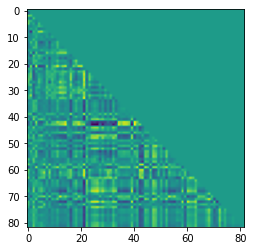

In [49]:
plt.imshow(conarray[:,:,1])